<a href="https://colab.research.google.com/github/MehrnazSadeghieh/Data-Mining-Second-Project/blob/main/Netflix_Data_Mining_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
!pip install transformers
!pip install torch
!pip install transformers
!pip install sentence-transformers
from transformers import BertTokenizer, BertModel
import torch
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading the dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/netflix.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [ ]:
missing_values = df.isnull().sum()
missing_values

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

# Start Preprocessing the dataset

In [ ]:
#Remove country column
df = df.drop('country', axis=1)
#Check if the title contains a date then remove it
df = df[~df['title'].apply(lambda x: any(item.isdigit() for item in x.split()))]
df = df.reset_index(drop=True)

In [ ]:
#Check if date_added is before the released year
df['date_added'] = pd.to_datetime(df['date_added'])
df['release_year'] = pd.to_datetime(df['release_year'], format='%Y')
df = df[df['date_added'] >= df['release_year']]
df = df.reset_index(drop=True)

In [ ]:
#Check if Tv-shows has min for duration and movies has season for duration
df = df[~((df['type'] == 'Movie') & (df['duration'].str.contains('Season')))]
df = df[~((df['type'] == 'TV Show') & (df['duration'].str.contains('min')))]
df = df.reset_index(drop=True)

***Remove outliers from type column***

In [ ]:
movies = df[df['type'] == 'Movie']
tv_shows = df[df['type'] == 'TV Show']

# Remove "min" from duration for movies
movies['duration'] = movies['duration'].str.extract('(\d+)').astype(float)

# Remove "Seasons" from duration for TV shows
tv_shows['duration'] = tv_shows['duration'].str.extract('(\d+)').astype(float)

# Movies
Q1_movies = movies['duration'].quantile(0.25)
Q3_movies = movies['duration'].quantile(0.75)
IQR_movies = Q3_movies - Q1_movies
lower_fence_movies = Q1_movies - 1.5 * IQR_movies
upper_fence_movies = Q3_movies + 1.5 * IQR_movies


# TV Shows
Q1_tv_shows = tv_shows['duration'].quantile(0.25)
Q3_tv_shows = tv_shows['duration'].quantile(0.75)
IQR_tv_shows = Q3_tv_shows - Q1_tv_shows

lower_fence_tv_shows = Q1_tv_shows - 1.5 * IQR_tv_shows
upper_fence_tv_shows = Q3_tv_shows + 1.5 * IQR_tv_shows

# Remove outlier rows from movies
movies = movies[(movies['duration'] >= lower_fence_movies) & (movies['duration'] <= upper_fence_movies)]

# Remove outlier rows from TV shows
tv_shows = tv_shows[(tv_shows['duration'] > 0)]

df = pd.concat([movies, tv_shows])

# Sort the dataframe by show_id
df = df.sort_values('show_id')

df = df.reset_index(drop=True)

<ipython-input-34-282620b3ccc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['duration'] = movies['duration'].str.extract('(\d+)').astype(float)
<ipython-input-34-282620b3ccc6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['duration'] = tv_shows['duration'].str.extract('(\d+)').astype(float)


In [ ]:
# Fill null cells in the "director" and "rating" column with the cell above it
df['director'] = df['director'].fillna(method='ffill')
df['rating'] = df['rating'].fillna(method='ffill')

In [ ]:
#Fill missing values of cast column

for index, row in df.iterrows():
    if pd.isnull(row['cast']):
        director = row['director']
        # Find the first row with the same director name
        director_row = df[df['director'] == director].iloc[0]
        # Fill the null cast value with the cast from the director_row
        df.at[index, 'cast'] = director_row['cast']

df = df.dropna(subset=['cast'])
#Sort cast in alphabetical order
df['sorted_cast'] = df['cast'].apply(lambda x: ' '.join(sorted(x.split(','))))

<ipython-input-36-a0c4beba3a8f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sorted_cast'] = df['cast'].apply(lambda x: ' '.join(sorted(x.split(','))))


In [ ]:
#Now we handled all missing values
missing_values = df.isnull().sum()
missing_values

show_id         0
type            0
title           0
director        0
cast            0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
sorted_cast     0
dtype: int64

In [ ]:
#Stemmizing Description column
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess the description text
def preprocess_description(text):
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize into individual words
    words = nltk.word_tokenize(text)

    # Remove stopwords and stem each word using the Porter stemmer
    stemmed_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]

    # Join the stemmed words
    processed_text = ' '.join(stemmed_words)

    return processed_text

df['description'] = df['description'].apply(preprocess_description)

In [ ]:
# Function to preprocess the listed_in text
def preprocess_listed_in(text):
    # Remove specific words and characters using regular expressions
    text = re.sub(r'\b(TV Shows|Movies|TV)\b', '', text)
    text = re.sub(r'[&,]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text.strip())
    return text
# Apply the preprocessing function to the "listed_in" column
df['listed_in'] = df['listed_in'].apply(preprocess_listed_in)
df['sorted_genres'] = df['listed_in'].apply(lambda x: ' '.join(sorted(x.split())))
df

,show_id,type,title,director,cast,date_added,release_year,rating,duration,listed_in,description,sorted_cast,sorted_genres
1,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",2021-09-24,2021-01-01,PG-13,104.0,Comedies Dramas,woman adjust life loss contend feisti bird tha...,Chris O'Dowd Daveed Diggs Kevin Kline Kimb...,Comedies Dramas
2,s100,TV Show,On the Verge,Theodore Melfi,"Julie Delpy, Elisabeth Shue, Sarah Jones, Alex...",2021-09-07,2021-01-01,TV-MA,1.0,Comedies Dramas,four women chef singl mom heiress job seeker d...,Alexia Landeau Elisabeth Shue Giovanni Ribi...,Comedies Dramas
3,s1000,Movie,Stowaway,Joe Penna,"Anna Kendrick, Toni Collette, Daniel Dae Kim, ...",2021-04-22,2021-01-01,TV-MA,116.0,Dramas International Thrillers,threeperson crew mission mar face imposs choic...,Daniel Dae Kim Shamier Anderson Toni Collet...,Dramas International Thrillers
4,s1001,Movie,Wild Dog,Ahishor Solomon,"Nagarjuna Akkineni, Dia Mirza, Saiyami Kher, A...",2021-04-22,2020-01-01,TV-MA,126.0,Action Adventure International,brash brilliant indian intellig agent lead cov...,Ali Reza Atul Kulakarni Bilal Hussain Dia ...,Action Adventure International
5,s1002,Movie,Oloibiri,Curtis Graham,"Olu Jacobs, Richard Mofe-Damijo, William R. Mo...",2021-04-21,2015-01-01,TV-14,86.0,Dramas International Thrillers,drill deplet small villag corpor find oil regi...,Bradley Gordon Dayton Sinkia Ifeanyi Willia...,Dramas International Thrillers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8072,s995,Movie,This Lady Called Life,Kayode Kasum,"Bisola Aiyeola, Efa Iwara, Molawa Onajobi, Tin...",2021-04-23,2020-01-01,TV-14,120.0,Dramas International Romantic,abandon famili young singl mother aiy struggl ...,Efa Iwara Jemima Osunde Lota Chukwu Michae...,Dramas International Romantic
8073,s996,Movie,Vizontele,"Yılmaz Erdoğan, Ömer Faruk Sorak","Yılmaz Erdoğan, Demet Akbağ, Altan Erkekli, Ce...",2021-04-23,2001-01-01,TV-MA,106.0,Comedies Dramas International,1974 rural town anatolia get first televis set...,Altan Erkekli Bican Günalan Cem Yılmaz Cez...,Comedies Dramas International
8074,s997,Movie,HOMUNCULUS,Takashi Shimizu,"Go Ayano, Ryo Narita, Yukino Kishii, Anna Ishi...",2021-04-22,2021-01-01,TV-MA,116.0,Horror International Thrillers,truth illus blur homeless amnesiac awaken expe...,Anna Ishii Ryo Narita Seiyo Uchino Yukino ...,Horror International Thrillers
8075,s998,TV Show,Life in Color with David Attenborough,Takashi Shimizu,David Attenborough,2021-04-22,2021-01-01,TV-PG,1.0,British Docuseries International,use innov technolog docuseri explor natur fres...,David Attenborough,British Docuseries International


Rajiv Chilaka             39
Marcus Raboy              27
Jay Karas                 23
Raúl Campos, Jan Suter    21
Jay Chapman               17
                          ..
Eric Laneuville            1
Joel Oliansky              1
Roy Campanella II          1
Arthur Allan Seidelman     1
Sylvain White              1
Name: director, Length: 3960, dtype: int64


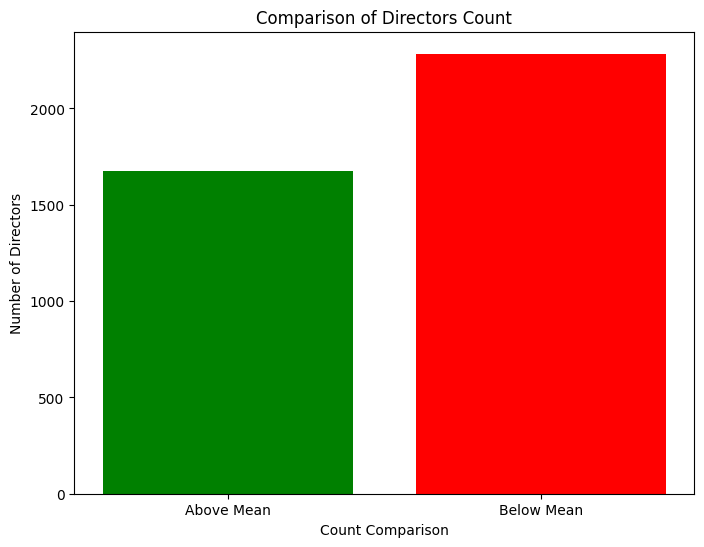

In [ ]:
# Calculate the number of movies or TV shows for each director
director_counts = df['director'].value_counts()
print(director_counts)
# Calculate the average number of movies or TV shows for all directors
average_count = director_counts.mean()

# Create a boolean mask to identify directors with counts higher than the mean
higher_than_mean = director_counts > average_count

# Count the number of directors above and below the mean
num_above_mean = higher_than_mean.sum()
num_below_mean = (~higher_than_mean).sum()

# Create a plot
plt.figure(figsize=(8, 6))
plt.bar(['Above Mean', 'Below Mean'], [num_above_mean, num_below_mean], color=['green', 'red'])
plt.xlabel('Count Comparison')
plt.ylabel('Number of Directors')
plt.title('Comparison of Directors Count')
plt.show()

# Extracting frequent patterns

In [ ]:
# Combine the three columns into a single column called "combined"
df['combined'] = df['sorted_cast'] + ',' + df['director'] + ',' + df['sorted_genres']

# Create a transaction list from the "combined" column
transactions = df['combined'].str.split(',')
# Apply one-hot encoding to the transaction list
te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm to find frequent itemsets
min_support = 0.001  # Adjust the minimum support as desired
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print(rules)

                                          antecedents  \
0                                       ( Alan Hicks)   
1                                     (Rashida Jones)   
2                                        ( Jan Suter)   
3                                       (Raúl Campos)   
4                                        ( Jan Suter)   
5   ( Jigna Bhardwaj  Julie Tejwani  Mousam  Rajes...   
6   ( Jigna Bhardwaj  Julie Tejwani  Mousam  Rajes...   
7                                    ( Mariano Mucci)   
8                                 ( Luis A. Scalella)   
9                                   (Marcelo Altmark)   
10                                ( Luis A. Scalella)   
11                                  (Marcelo Altmark)   
12                                   ( Mariano Mucci)   
13                                     ( Megan Siler)   
14                                    (Ellen Seidler)   
15                                    (Prakash Satam)   
16                             

# Clustering the vectorized description

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' i

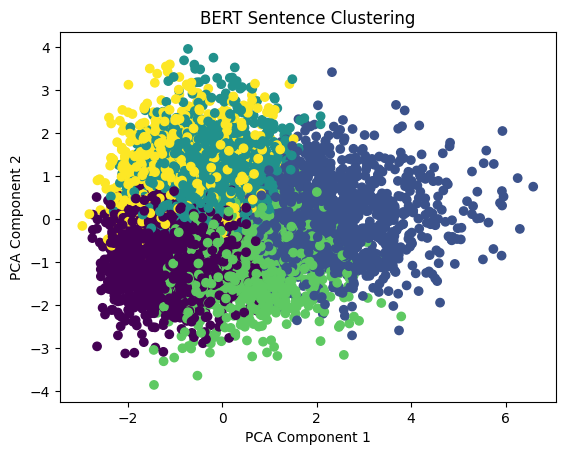

In [ ]:
model = SentenceTransformer('bert-base-uncased')
descriptions = df['description'].tolist()
description_vectors = model.encode(descriptions)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(description_vectors)
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(description_vectors)
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels)
plt.title('BERT Sentence Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

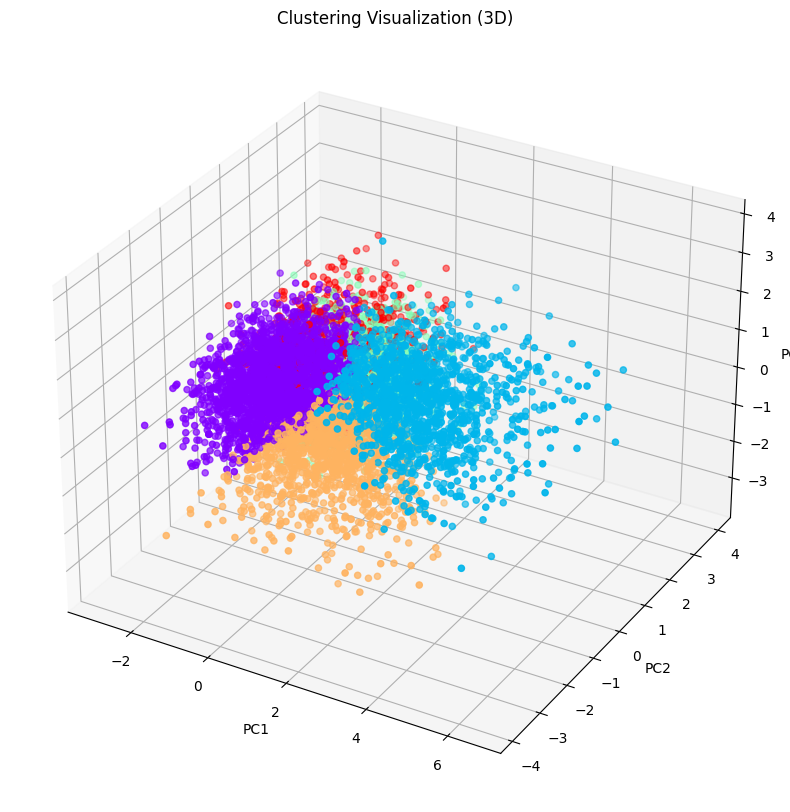

In [ ]:
# Visualizing the 3D model of clustering
# Apply PCA for dimensionality reduction to 3 dimensions
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(description_vectors)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=cluster_labels, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Clustering Visualization (3D)')
plt.show()

# Classification

In [ ]:
# Number of all labels we have in combined genres scenario
num_unique_genres = df['sorted_genres'].nunique()
print("Number of unique genres:", num_unique_genres)

Number of unique genres: 459


***Classification based on first scenario***

In [ ]:
genres = df['sorted_genres']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(description_vectors, genres, test_size=0.1, random_state=42)

# Fit the label encoder on the combined genre set
label_encoder = LabelEncoder()
label_encoder.fit(genres)

# Encode the train and test genres
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build and train the classification model
classifier = LogisticRegression()
classifier.fit(X_train, y_train_encoded)

# Evaluate the model on the testing set
accuracy = classifier.score(X_test, y_test_encoded)
print('Test accuracy:', accuracy)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Decode the predicted labels back to genre names
predicted_genres = label_encoder.inverse_transform(predictions)
print('Predicted genres:', predicted_genres)

Test accuracy: 0.20703125
Predicted genres: ['Comedy Stand-Up' 'Anime International Series' 'Reality'
 'Dramas Independent International' 'Dramas International Thrillers'
 'Children Family' "Kids' Korean" 'Anime International Series'
 'Docuseries Nature Science' 'Action Adventure International'
 'British Comedies' 'Children Family' 'Dramas'
 'Comedies International Romantic' 'Anime International Series'
 'Children Comedies Family' 'Action Adventure'
 'Dramas Independent International' 'Dramas International Romantic'
 'Comedy Stand-Up' 'Documentaries' 'Comedies International Music Musicals'
 'Action Adventure' 'Comedies International Romantic' "Kids'"
 'Comedy Stand-Up' 'Dramas Thrillers' 'Dramas International'
 'Comedy Stand-Up' 'Action Adventure Fantasy Sci-Fi'
 'Comedies Dramas International' "Kids'" 'Anime International Series Teen'
 'Children Family' 'Comedies Dramas International'
 'Dramas International Thrillers' 'Children Family'
 'Action Adventure Fantasy Horror Sci-Fi' 'Comedi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#Extract the first genre as the main one
df['main_genre'] = df['sorted_genres'].str.split().str[0]

num_unique_genres = df['main_genre'].nunique()
print("Number of unique genre:", num_unique_genres)

Number of unique genre: 24


***Classification based on second scenario***

In [ ]:
genres = df['main_genre']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(description_vectors, genres, test_size=0.2, random_state=42)

# Fit the label encoder on the combined genre set
label_encoder = LabelEncoder()
label_encoder.fit(genres)

# Encode the train and test genres
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build and train the classification model
classifier = LogisticRegression()
classifier.fit(X_train, y_train_encoded)

# Evaluate the model on the testing set
accuracy = classifier.score(X_test, y_test_encoded)
print('Test accuracy:', accuracy)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Decode the predicted labels back to genre names
predicted_genres = label_encoder.inverse_transform(predictions)
print('Predicted genres:', predicted_genres)

Test accuracy: 0.427734375
Predicted genres: ['Comedy' 'Action' 'Comedies' ... 'Comedy' 'Comedies' 'Comedy']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
